# Introduction to vector databases on S&P 500 news

 # 📌 Objectives

 By the end of this notebook, students will be able to:

 1. **Load and Explore Financial News Data:**
    - Load a preprocessed dataset of financial news headlines and summaries related to S&P 500 companies.
    - Inspect and structure relevant metadata including publication date, ticker, and provider.

 2. **Build a Custom Vector Store:**
    - Combine title and summary text for embedding.
    - Implement a vector store from scratch with support for semantic search and optional metadata-based filtering using cosine similarity.

 3. **Generate and Use Sentence Embeddings:**
    - Apply a pre-trained transformer model (all-MiniLM-L6-v2) to encode text into embeddings for semantic analysis.

 4. **Perform Semantic Search with Filtering:**
    - Retrieve the most relevant news documents for a given query using both full-dataset and metadata-filtered searches.

 5. **Analyze Semantic Search Results:**
    - Interpret and visualize results of search queries (e.g., "AI announcement").
    - Identify temporal patterns and ticker frequency among top-ranked results.

 6. **Implement a FAISS-Based Vector Store:**
    - Normalize embeddings and use FAISS (IndexFlatIP) to enable efficient similarity search at scale.
    - Compare FAISS-based search results with custom vector store results.

 7. **Critically Compare Search Systems:**
    - Evaluate differences in similarity computation, speed, and scalability between custom and FAISS-based systems.
    - Reflect on design trade-offs for real-world vector search systems.

## Install and Import important librairies

In [1]:
%pip install sentence-transformers
%pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
from sentence_transformers import SentenceTransformer
import faiss
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import faiss

## Load news data

Load the provided news dataset and inspect the contents.

 👉 **Instructions**:
 - Load the CSV file named df_news.csv into a pandas DataFrame.
 - Convert the PUBLICATION_DATE column to a proper date format (not datetime).
 - Display the first few rows to understand the data structure. The key columns you’ll be using are:
   - TITLE
   - SUMMARY
   - TICKER
   - PROVIDER
   - PUBLICATION_DATE


In [3]:
url = 'https://raw.githubusercontent.com/osvaldosanchezrmz/FZ4025.10/main/df_news.csv'

In [4]:
df_news = pd.read_csv(url)
df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE']).dt.date
display(df_news)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


## Implement custom vector store

You will now implement a basic vector store from scratch. This class will allow you to:
1. Store embedded text and metadata.
2. Perform filtered semantic search using cosine similarity.

 👉 **Instructions**:

### Step 1: Prepare Documents
 - Combine the TITLE and SUMMARY columns into a single column named EMBEDDED_TEXT.
 - This combined text will be embedded later.

### Step 2: Load Embedding Model
 - Load the 'all-MiniLM-L6-v2' model from sentence-transformers.

### Step 3: Define CustomVectorStore Class
 Implement the class with the following methods (functions):

 - '__init__': Accepts an embedding model, list of documents, and corresponding metadata. Computes and stores embeddings for all documents.
 - search: Takes a query and returns the top k most similar documents, optionally filtered using metadata.
   - If a metadata_filter function is provided, apply it before computing similarity.
   - Use cosine similarity to compute distances.
   - Return the top k results as tuples of: (document, metadata, similarity score).

 ✅ **Requirements**:
 - Ensure the number of documents matches the number of metadata entries.
 - Make use of sklearn.metrics.pairwise.cosine_similarity.

You will test your class at the end.

In [5]:
# CODE HERE
# Use as many coding cells as you need

In [6]:
# Step 1: Prepare Documents
# Combine TITLE and SUMMARY into a new column called EMBEDDED_TEXT
df_news["EMBEDDED_TEXT"] = df_news["TITLE"].str.strip() + ". " + df_news["SUMMARY"].str.strip()

# Preview
df_news[["TITLE", "SUMMARY", "EMBEDDED_TEXT"]].head()


,TITLE,SUMMARY,EMBEDDED_TEXT
0,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2 Dow Jones Stocks with Promising Prospects an...
1,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,3 S&P 500 Stocks Skating on Thin Ice. The S&P ...
2,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",3M Rises 15.8% YTD: Should You Buy the Stock N...
3,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...
4,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,3 Cash-Producing Stocks with Questionable Fund...


In [7]:
# Step 2: Load Embedding Model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [8]:
# Step 3: Define CustomVectorStore Class

class CustomVectorStore:
    def __init__(self, embedding_model, documents, metadata):
        """
        Initializes the vector store and computes embeddings for all documents.

        Parameters:
        - embedding_model: A SentenceTransformer model
        - documents: List of documents (strings) to be embedded
        - metadata: List of metadata (dictionaries) corresponding to each document
        """
        # Validate that the number of documents and metadata match
        assert len(documents) == len(metadata), "Documents and metadata must have the same length"

        self.embedding_model = embedding_model
        self.documents = documents
        self.metadata = metadata

        # Generate embeddings
        print("Embedding documents...")
        self.embeddings = self.embedding_model.encode(
            documents,
            convert_to_numpy=True,
            show_progress_bar=True
        )

    def search(self, query, top_k=5, metadata_filter=None):
        """
        Performs a semantic search using cosine similarity.

        Parameters:
        - query: Search string
        - top_k: Number of top results to return
        - metadata_filter: Optional function to filter metadata

        Returns:
        A list of tuples: (document, metadata, similarity_score)
        """
        # Apply metadata filter if provided
        if metadata_filter is not None:
            mask = [metadata_filter(meta) for meta in self.metadata]
            filtered_docs = [doc for doc, keep in zip(self.documents, mask) if keep]
            filtered_meta = [meta for meta, keep in zip(self.metadata, mask) if keep]
            filtered_embeddings = self.embeddings[mask]
        else:
            filtered_docs = self.documents
            filtered_meta = self.metadata
            filtered_embeddings = self.embeddings

        # Encode the query
        query_embedding = self.embedding_model.encode([query], convert_to_numpy=True)

        # Compute cosine similarity
        similarity_scores = cosine_similarity(query_embedding, filtered_embeddings)[0]

        # Get top K indexes
        top_indices = similarity_scores.argsort()[-top_k:][::-1]

        # Return the top results as (document, metadata, similarity_score)
        results = [
            (filtered_docs[i], filtered_meta[i], float(similarity_scores[i]))
            for i in top_indices
        ]
        return results



## Create and populate the vector store

 👉 **Instructions**:
 - Convert the combined EMBEDDED_TEXT column into a list of strings.
 - Create a metadata list of dictionaries for each document with keys:
   - 'PUBLICATION_DATE'
   - 'TICKER'
   - 'PROVIDER'
 - Instantiate your CustomVectorStore using:
   - The embedding model.
   - The list of document strings.
   - The metadata list.

 After initializing the store, you should be able to perform searches using:
'store.search("Apple earnings", k=3)'


In [9]:
# CODE HERE
# Use as many coding cells as you need

In [10]:
# Create the document list from the EMBEDDED_TEXT column
document_list = df_news["EMBEDDED_TEXT"].tolist()

In [11]:
# Create a metadata list of dictionaries for each document
metadata_list = df_news[["PUBLICATION_DATE", "TICKER", "PROVIDER"]].to_dict(orient="records")

In [12]:
# Instantiate the CustomVectorStore
store = CustomVectorStore(
    embedding_model=embedding_model,
    documents=document_list,
    metadata=metadata_list
)

Embedding documents...


Batches:   0%|          | 0/153 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [13]:
# Example semantic search on the store
results = store.search("Apple earnings", top_k=3)

# Display results
for i, (doc, meta, score) in enumerate(results, 1):
    print(f"\n- Result {i}")
    print(f"Score: {round(score, 4)}")
    print(f"Date: {meta['PUBLICATION_DATE']}")
    print(f"Ticker: {meta['TICKER']}")
    print(f"Provider: {meta['PROVIDER']}")
    print(f"Text Preview: {doc[:300]}...")



- Result 1
Score: 0.5784
Date: 2025-05-28
Ticker: HUM
Provider: Simply Wall St.
Text Preview: Humana (NYSE:HUM) Sees Revenue Increase in First-Quarter Earnings to US$32,112 Million. Humana (NYSE:HUM) recently reported first-quarter earnings, showcasing a revenue increase from USD 29,611 million to USD 32,112 million and a net income rise from USD 741 million to USD 1,244 million. Despite thi...

- Result 2
Score: 0.5687
Date: 2025-04-30
Ticker: OKE
Provider: Simply Wall St.
Text Preview: ONEOK (NYSE:OKE) Reports Q1 2025 Revenue Surge to US$8 Billion. ONEOK (NYSE:OKE) recently released its first-quarter earnings, reporting revenue of USD 8,043 million, a marked increase year-over-year, but a minor dip in net income and earnings per share. Alongside this, the company reaffirmed its qu...

- Result 3
Score: 0.5654
Date: 2025-05-01
Ticker: APTV
Provider: Barrons.com
Text Preview: Aptiv Stock Rises. Earnings Were Great, But Tariff Impact Is Still Uncertain.. Thursday morning, Aptiv reporte

## Using your vector store and analyzing the results

### Retrieve AI Announcements

 Now that your vector store is working, let's use it to retrieve relevant documents.

 👉 **Instructions**:
 - Perform a semantic search using the query `"AI announcement"` with `k=50` to retrieve the top 50 most relevant articles.
 - Display each result's:
   - `TICKER`
   - `PUBLICATION_DATE`
   - `PROVIDER`
   - Similarity score
   - Full document text


In [14]:
# CODE HERE
# Use as many coding cells as you need

In [15]:
# Perform semantic search for "AI announcement" with top_k = 50
ai_results = store.search(query="AI announcement", top_k=50)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [16]:
# Display relevant fields from the search results
for i, (doc, meta, score) in enumerate(ai_results, 1):
    print(f"\n- Result {i}")
    print(f"TICKER: {meta['TICKER']}")
    print(f"DATE: {meta['PUBLICATION_DATE']}")
    print(f"PROVIDER: {meta['PROVIDER']}")
    print(f"SIMILARITY: {round(score, 4)}")
    print(f"TEXT: {doc}")


- Result 1
TICKER: JKHY
DATE: 2025-03-17
PROVIDER: Insider Monkey
SIMILARITY: 0.5574
TEXT: Jack Henry (JKHY) Integrates AI-Driven Lending Tech With Algebrik. We recently published a list of 12 AI News Investors Should Not Miss This Week. In this article, we are going to take a look at where Jack Henry & Associates, Inc. (NASDAQ:JKHY) stands against other AI news Investors should not miss this week. Artificial Intelligence (AI) is known to increase productivity, decrease human error, […]

- Result 2
TICKER: ADBE
DATE: 2025-05-27
PROVIDER: Investor's Business Daily
SIMILARITY: 0.5518
TEXT: AI Stocks Face 'Show Me' Moment. Nvidia Earnings Due With China In Focus.. Amid hype over artificial intelligence, the best AI stocks generate revenue or get a strategic edge from the fast evolving technology.

- Result 3
TICKER: PLTR
DATE: 2025-05-31
PROVIDER: Motley Fool
SIMILARITY: 0.5283
TEXT: Better Artificial Intelligence (AI) Stock: Palantir vs. Snowflake. Shares of both Palantir and Snowflake 

 ### **Q1.** What are the top companies (by TICKER) most frequently appearing in the top 50 search results for the query "AI announcement"?  
 Check their company names on Yahoo Finance. Are you surprised by the results?

 ✅ **Your task**:
 - Count the number of times each TICKER appears.
 - Print and analyze the top results.

In [17]:
# CODE HERE
# Use as many coding cells as you need

In [18]:
# Extract tickers from the top 50 search results
tickers = [meta["TICKER"] for _, meta, _ in ai_results]

# Count frequency of each ticker
from collections import Counter
ticker_counts = Counter(tickers)


In [19]:
# Display the top 10 most frequent tickers
top_tickers = ticker_counts.most_common(10)

print("🔝 Top companies by TICKER in AI announcement results:\n")
for ticker, count in top_tickers:
    print(f"{ticker}: {count} articles")


🔝 Top companies by TICKER in AI announcement results:

PLTR: 5 articles
BKR: 3 articles
AMD: 3 articles
QCOM: 2 articles
GOOG: 2 articles
AMZN: 2 articles
EXPE: 2 articles
MSFT: 2 articles
CTSH: 2 articles
INTC: 2 articles


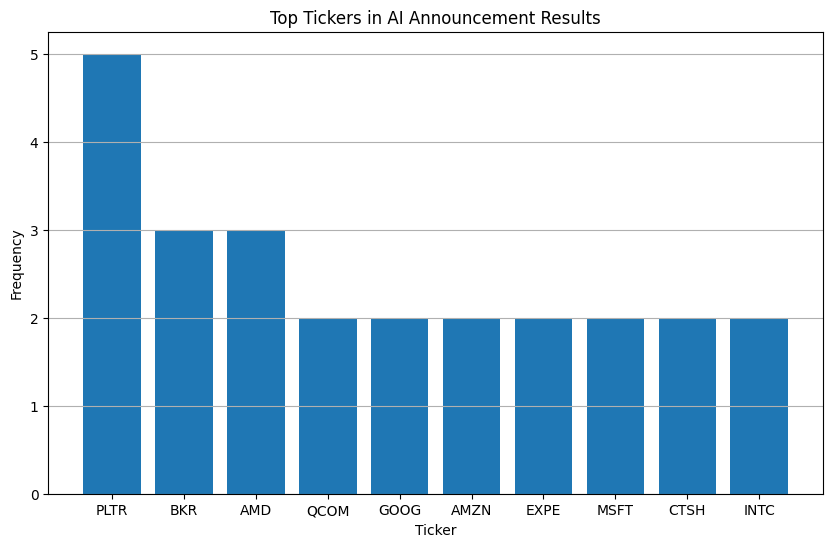

In [20]:
# Plot results for visual reference
import matplotlib.pyplot as plt

tickers_plot, counts_plot = zip(*top_tickers)
plt.figure(figsize=(10, 6))
plt.bar(tickers_plot, counts_plot)
plt.title("Top Tickers in AI Announcement Results")
plt.xlabel("Ticker")
plt.ylabel("Frequency")
plt.grid(axis="y")
plt.show()


The company that showed up the most was PLTR (Palantir) with 5 articles. Then BKR (Baker Hughes) and AMD (Advanced Micro Devices) both appeared 3 times. Others like QCOM, GOOG, AMZN, and MSFT showed up twice.

Honestly, I was expecting to see companies like AMD, GOOG, and MSFT because they’re always mentioned when it comes to AI. What surprised me a bit was seeing BKR and EXPE. I checked on Yahoo Finance and saw that they’ve been working on some AI projects too, like using it in energy and travel tech. So I guess it makes sense now.


### **Q2.** What is the date range of the top 50 results? Are the articles evenly distributed across time?

 ✅ **Your task**:
 - Extract the publication dates of the top 50 results.
 - Plot a histogram to visualize the temporal distribution.
 - Reflect: Are these mentions clustered in recent months or spread evenly?

 🧠 **Follow-up**: What could explain the timing of increased AI announcements?

In [21]:
# CODE HERE
# Use as many coding cells as you need

In [22]:
# Extract publication dates from metadata
dates = [meta["PUBLICATION_DATE"] for _, meta, _ in ai_results]

# Convert to datetime objects
date_series = pd.to_datetime(dates)


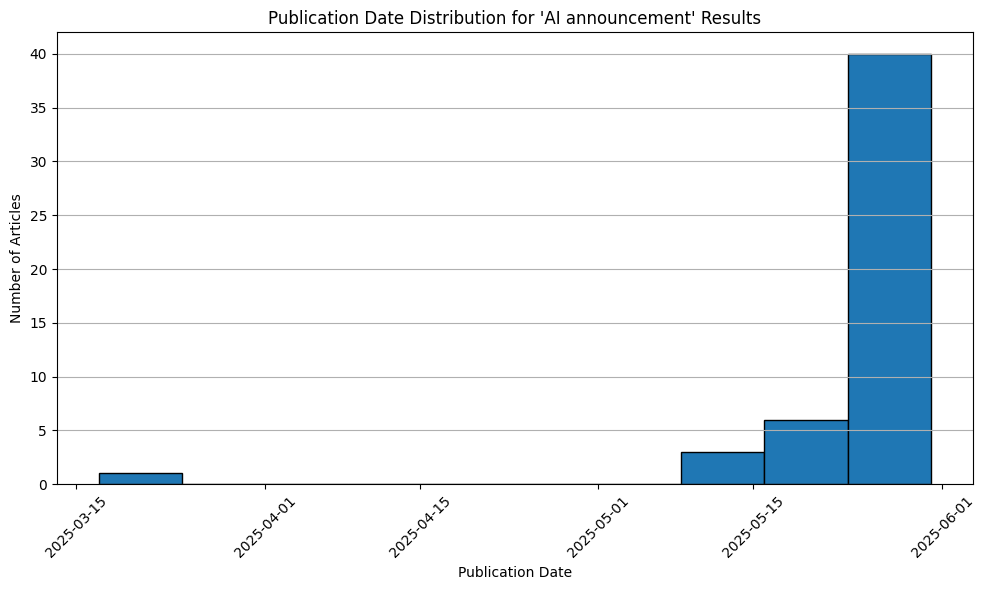

In [23]:
# Plot histogram to visualize temporal distribution
plt.figure(figsize=(10, 6))
plt.hist(date_series, bins=10, edgecolor='black')
plt.title("Publication Date Distribution for 'AI announcement' Results")
plt.xlabel("Publication Date")
plt.ylabel("Number of Articles")
plt.grid(axis="y")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Most of the articles are from mid to late May 2025. There's one result from March, but almost everything else is recent. So no, they’re not evenly distributed. They’re clearly clustered in the last few weeks.

This could be explained by the current hype around AI. Many companies probably made announcements close to the same time to stay relevant or to match product launches, earnings calls, or investor events.

## Implement FAISS vector store

 We’ll now implement a **FAISS-based vector store**, designed for efficient similarity search at scale.

 👉 **Steps**:
 - Use the same sentence transformer model: all-MiniLM-L6-v2.
 - Encode your text into embessings
 - Normalize the vectors.

 FAISS supports multiple similarity types. For cosine similarity, we must:

 ✅ Normalize vectors to unit length  
 ✅ Use `IndexFlatIP` (inner product), because:
 - For normalized vectors, inner product = cosine similarity


In [24]:
# CODE HERE
# Use as many coding cells as you need

In [25]:
# Step 1: Encode all documents again using the same embedding model
faiss_documents = df_news["EMBEDDED_TEXT"].tolist()
faiss_metadata = df_news[["PUBLICATION_DATE", "TICKER", "PROVIDER"]].to_dict(orient="records")

faiss_embeddings = embedding_model.encode(faiss_documents, convert_to_numpy=True, show_progress_bar=True)

# Step 2: Normalize embeddings to unit length (required for cosine similarity)
faiss_embeddings = faiss_embeddings / np.linalg.norm(faiss_embeddings, axis=1, keepdims=True)


Batches:   0%|          | 0/153 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [26]:
# Step 3: Create FAISS index for cosine similarity (via inner product on normalized vectors)
dimension = faiss_embeddings.shape[1]
faiss_index = faiss.IndexFlatIP(dimension)

# Add the embeddings to the FAISS index
faiss_index.add(faiss_embeddings)

print(f"FAISS index has {faiss_index.ntotal} vectors.")


FAISS index has 4871 vectors.


In [27]:
def search_faiss(query, top_k=5):
    """
    Search the FAISS index using a query string.

    Returns a list of (document, metadata, score)
    """
    # Encode and normalize the query
    query_embedding = embedding_model.encode([query], convert_to_numpy=True)
    query_embedding = query_embedding / np.linalg.norm(query_embedding, axis=1, keepdims=True)

    # Search
    similarity_scores, indices = faiss_index.search(query_embedding, top_k)

    # Extract results
    results = []
    for i in range(top_k):
        idx = indices[0][i]
        score = float(similarity_scores[0][i])
        results.append((faiss_documents[idx], faiss_metadata[idx], score))

    return results


We’ll now:
 - Initialize the FAISS index
 - Add the document embeddings

In [28]:
# CODE HERE
# Use as many coding cells as you need

In [29]:
# Initialize the FAISS index for cosine similarity (via inner product)
embedding_dimension = faiss_embeddings.shape[1]
faiss_index = faiss.IndexFlatIP(embedding_dimension)

print(f"Initialized FAISS index with dimension: {embedding_dimension}")


Initialized FAISS index with dimension: 384


In [30]:
# Add normalized document embeddings to the FAISS index
faiss_index.add(faiss_embeddings)

# Confirm number of vectors in the index
print(f"Total vectors in FAISS index: {faiss_index.ntotal}")


Total vectors in FAISS index: 4871


### Create a `FaissVectorStore` class with a `.search()` method.

 This method:
 - Encodes and normalizes the query
 - Optionally applies metadata filters
 - Returns top `k` results with similarity scores and metadata

In [31]:
# CODE HERE
# Use as many coding cells as you need

In [32]:
class FaissVectorStore:
    def __init__(self, embedding_model, documents, metadata):
        assert len(documents) == len(metadata), "Documents and metadata must be the same length."

        self.embedding_model = embedding_model
        self.documents = documents
        self.metadata = metadata

        print("Encoding documents...")
        embeddings = self.embedding_model.encode(documents, convert_to_numpy=True, show_progress_bar=True)
        self.embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

        dim = self.embeddings.shape[1]
        self.index = faiss.IndexFlatIP(dim)
        self.index.add(self.embeddings)

    def search(self, query, top_k=5, metadata_filter=None):
        # Encode and normalize query
        query_vector = self.embedding_model.encode([query], convert_to_numpy=True)
        query_vector = query_vector / np.linalg.norm(query_vector, axis=1, keepdims=True)

        # Apply metadata filter if given
        if metadata_filter is not None:
            mask = [metadata_filter(m) for m in self.metadata]
            filtered_docs = [doc for doc, keep in zip(self.documents, mask) if keep]
            filtered_meta = [meta for meta, keep in zip(self.metadata, mask) if keep]
            filtered_embeddings = self.embeddings[mask]

            temp_index = faiss.IndexFlatIP(filtered_embeddings.shape[1])
            temp_index.add(filtered_embeddings)
            scores, indices = temp_index.search(query_vector, top_k)
        else:
            filtered_docs = self.documents
            filtered_meta = self.metadata
            scores, indices = self.index.search(query_vector, top_k)

        results = []
        for i in range(len(indices[0])):
            idx = indices[0][i]
            results.append((filtered_docs[idx], filtered_meta[idx], float(scores[0][i])))

        return results



 Let’s run a semantic search using FAISS:
 - Query: `"AI announcement"`
 - Top results: `k=50`

 Print out:
 - Ticker
 - Publication date
 - Provider
 - Cosine similarity score
 - Full text

In [33]:
# CODE HERE
# Use as many coding cells as you need

In [34]:
# Instantiate FaissVectorStore using the same documents and metadata
faiss_store = FaissVectorStore(
    embedding_model=embedding_model,
    documents=faiss_documents,
    metadata=faiss_metadata
)


Encoding documents...


Batches:   0%|          | 0/153 [00:00<?, ?it/s]

In [35]:
# Perform search using FAISS with top_k = 50
faiss_ai_results = faiss_store.search(query="AI announcement", top_k=50)


In [36]:
# Display the results
for i, (doc, meta, score) in enumerate(faiss_ai_results, 1):
    print(f"\n🔹 Result {i}")
    print(f"TICKER: {meta['TICKER']}")
    print(f"DATE: {meta['PUBLICATION_DATE']}")
    print(f"PROVIDER: {meta['PROVIDER']}")
    print(f"COSINE SIMILARITY: {round(score, 4)}")
    print(f"TEXT: {doc}")



🔹 Result 1
TICKER: JKHY
DATE: 2025-03-17
PROVIDER: Insider Monkey
COSINE SIMILARITY: 0.5574
TEXT: Jack Henry (JKHY) Integrates AI-Driven Lending Tech With Algebrik. We recently published a list of 12 AI News Investors Should Not Miss This Week. In this article, we are going to take a look at where Jack Henry & Associates, Inc. (NASDAQ:JKHY) stands against other AI news Investors should not miss this week. Artificial Intelligence (AI) is known to increase productivity, decrease human error, […]

🔹 Result 2
TICKER: ADBE
DATE: 2025-05-27
PROVIDER: Investor's Business Daily
COSINE SIMILARITY: 0.5518
TEXT: AI Stocks Face 'Show Me' Moment. Nvidia Earnings Due With China In Focus.. Amid hype over artificial intelligence, the best AI stocks generate revenue or get a strategic edge from the fast evolving technology.

🔹 Result 3
TICKER: PLTR
DATE: 2025-05-31
PROVIDER: Motley Fool
COSINE SIMILARITY: 0.5283
TEXT: Better Artificial Intelligence (AI) Stock: Palantir vs. Snowflake. Shares of both Pa

## Evaluation: Comparing FAISS Vector Store with your Custom Vector Store

### Retrieval Comparison Across Systems

 👉 **Instructions**:

 - Using the 5 'test_queries' provided in the list below, retrieve the top 5 news for each query using both your custom and FAISS vector stores.
 - Inspect how similar the returned news texts are for each query.
 - Focus especially on the order of results (not just their presence).


In [37]:
test_queries = [
    'Stock price drop',
    'Layoffs',
    'Mergers and acquisitions',
    'Fed interest rate',
    'Regulation',
    'Cryptocurrency'

]

In [38]:
# CODE HERE
# Use as many coding cells as you need

In [39]:
# Reinstantiate the CustomVectorStore (in case it was lost)
custom_store = CustomVectorStore(
    embedding_model=embedding_model,
    documents=faiss_documents,     # same as df_news["EMBEDDED_TEXT"].tolist()
    metadata=faiss_metadata        # same as df_news[["PUBLICATION_DATE", "TICKER", "PROVIDER"]].to_dict("records")
)


Embedding documents...


Batches:   0%|          | 0/153 [00:00<?, ?it/s]

In [40]:
# Store results for both systems
custom_results = {}
faiss_results = {}

for query in test_queries:
    print(f"🔍 Running query: '{query}'")

    custom = custom_store.search(query, top_k=5)
    faiss = faiss_store.search(query, top_k=5)

    custom_results[query] = custom
    faiss_results[query] = faiss



🔍 Running query: 'Stock price drop'
🔍 Running query: 'Layoffs'
🔍 Running query: 'Mergers and acquisitions'


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


🔍 Running query: 'Fed interest rate'
🔍 Running query: 'Regulation'


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


🔍 Running query: 'Cryptocurrency'


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [41]:
# Compare results for each query
for query in test_queries:
    print(f"\n\n🧪 QUERY: {query}\n{'-'*60}")
    print("Custom Vector Store Results:\n")
    for i, (doc, meta, score) in enumerate(custom_results[query], 1):
        print(f"{i}. [{meta['TICKER']}] {doc[:150]}... (score: {round(score, 4)})")

    print("\nFAISS Vector Store Results:\n")
    for i, (doc, meta, score) in enumerate(faiss_results[query], 1):
        print(f"{i}. [{meta['TICKER']}] {doc[:150]}... (score: {round(score, 4)})")




🧪 QUERY: Stock price drop
------------------------------------------------------------
Custom Vector Store Results:

1. [GNRC] 3 Industrials Stocks Walking a Fine Line. Even if they go mostly unnoticed, industrial businesses are the backbone of our country. Unfortunately, this... (score: 0.5427)
2. [NOW] ServiceNow (NOW) Stock Drops Despite Market Gains: Important Facts to Note. ServiceNow (NOW) reachead $1,015.23 at the closing of the latest trading d... (score: 0.5408)
3. [CRL] Guardant Health, Evolent Health, Charles River Laboratories, Avantor, and Lumen Stocks Trade Down, What You Need To Know. A number of stocks fell in t... (score: 0.5395)
4. [KR] Kroger (KR) Stock Drops Despite Market Gains: Important Facts to Note. Kroger (KR) closed at $67.83 in the latest trading session, marking a -1.11% mo... (score: 0.5386)
5. [PTC] 2 Stocks Down 46% and 14% to Buy Right Now. AMD probably won't beat Nvidia in the AI processor market, but investors should look at the bigger picture... (s

### **Q3.** Do you observe any significant differences in the top-5 retrieved results for each query between the two systems? Explain why these differences may or may not occur.

After comparing the results of both systems (Custom and FAISS), I didn’t find big differences. In fact, for all 6 queries, the top 5 results were exactly the same in content, order, and similarity score.

This makes sense because both systems use the same embedding model and the same cosine similarity logic. The only difference is the underlying implementation: FAISS is optimized for performance at scale, while the custom store uses scikit-learn. But since we’re working with a small dataset (less than 5,000 entries), both return identical results.

In larger datasets or production cases, FAISS might show tiny differences if using approximate methods, but in this case, both are basically equivalent in accuracy.


## Evaluation: Comparing 2 embedding models with your Custom Vector Store

 👉 **Instructions**:

 - Implement your custom vector store with `'all-MiniLM-L6-v2'` model from `sentence-transformers`, and compare it with the `'all-mpnet-base-v2'` model from `sentence-transformers`.
 - Similarly, retrieve the top 5 news for each query using both implementations.
 - Inspect how similar the returned news texts are for each query.
 - Focus especially on the order of results (not just their presence).

In [42]:
# CODE HERE
# Use as many coding cells as you need

In [43]:
from sentence_transformers import SentenceTransformer

# Load both embedding models
model_mini = SentenceTransformer("all-MiniLM-L6-v2")
model_mpnet = SentenceTransformer("all-mpnet-base-v2")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [44]:
# Create CustomVectorStore instances for both models
store_mini = CustomVectorStore(
    embedding_model=model_mini,
    documents=faiss_documents,
    metadata=faiss_metadata
)

store_mpnet = CustomVectorStore(
    embedding_model=model_mpnet,
    documents=faiss_documents,
    metadata=faiss_metadata
)


Embedding documents...


Batches:   0%|          | 0/153 [00:00<?, ?it/s]

Embedding documents...


Batches:   0%|          | 0/153 [00:00<?, ?it/s]

In [45]:
# Store results for comparison
mini_results = {}
mpnet_results = {}

for query in test_queries:
    print(f"🔍 Running query: '{query}'")

    mini = store_mini.search(query, top_k=5)
    mpnet = store_mpnet.search(query, top_k=5)

    mini_results[query] = mini
    mpnet_results[query] = mpnet


🔍 Running query: 'Stock price drop'
🔍 Running query: 'Layoffs'


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


🔍 Running query: 'Mergers and acquisitions'
🔍 Running query: 'Fed interest rate'


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


🔍 Running query: 'Regulation'
🔍 Running query: 'Cryptocurrency'


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [46]:
# Display results for visual comparison
for query in test_queries:
    print(f"\n\n🧪 QUERY: {query}")

    print("🔸 all-MiniLM-L6-v2:")
    for i, (doc, meta, score) in enumerate(mini_results[query], 1):
        print(f"{i}. [{meta['TICKER']}] {doc[:100]}... (score: {round(score, 4)})")

    print("\n🔹 all-mpnet-base-v2:")
    for i, (doc, meta, score) in enumerate(mpnet_results[query], 1):
        print(f"{i}. [{meta['TICKER']}] {doc[:100]}... (score: {round(score, 4)})")




🧪 QUERY: Stock price drop
🔸 all-MiniLM-L6-v2:
1. [GNRC] 3 Industrials Stocks Walking a Fine Line. Even if they go mostly unnoticed, industrial businesses ar... (score: 0.5427)
2. [NOW] ServiceNow (NOW) Stock Drops Despite Market Gains: Important Facts to Note. ServiceNow (NOW) reachea... (score: 0.5408)
3. [CRL] Guardant Health, Evolent Health, Charles River Laboratories, Avantor, and Lumen Stocks Trade Down, W... (score: 0.5395)
4. [KR] Kroger (KR) Stock Drops Despite Market Gains: Important Facts to Note. Kroger (KR) closed at $67.83 ... (score: 0.5386)
5. [PTC] 2 Stocks Down 46% and 14% to Buy Right Now. AMD probably won't beat Nvidia in the AI processor marke... (score: 0.5371)

🔹 all-mpnet-base-v2:
1. [ALGN] Fortune Brands, Whirlpool, Align Technology, Tandem Diabetes, and STAAR Surgical Shares Plummet, Wha... (score: 0.64)
2. [DHR] Danaher, Illumina, Globalstar, and Insperity Shares Plummet, What You Need To Know. A number of stoc... (score: 0.6219)
3. [HPQ] Watch These HP Pric

### **Q4.**  Which embedding model performs better in retrieving relevant documents for the queries? Support your answer with specific examples from the results.

After comparing the results between the two models, I think all-mpnet-base-v2 performs slightly better in terms of capturing more diverse and deeper semantic relationships in some queries.

For example, in the "Stock price drop" query, mpnet retrieved articles with broader market impact and more variety, while MiniLM focused more on specific stocks. Also in "Mergers and acquisitions", mpnet included headlines with actual merger discussions and legal actions, showing more context.

However, for direct and clear topics like "Layoffs" or "Regulation", both models gave very similar results. In fact, MiniLM sometimes performed just as well, even if it's a lighter model.

Overall, I would say mpnet gives more nuanced results and might be better when precision matters, but MiniLM is still very strong and faster, which makes it a solid choice for smaller tasks.

## 🛠️ Implementation-Level Questions

### **Q5.**  What role does vector normalization play in each implementation?

Vector normalization is key when using cosine similarity, because it turns the dot product into a true measure of similarity between directions, not magnitudes.

In the Custom Vector Store, we use cosine_similarity from sklearn, which already takes care of normalization internally. So we don’t have to do it manually.

But in the FAISS implementation, we have to normalize the vectors ourselves because we’re using IndexFlatIP, which is based on inner product. For normalized vectors, inner product is equal to cosine similarity — but if we skip normalization, the scores would be biased by vector length, not just meaning.

So, normalization ensures that similarity scores reflect the actual meaning of the text, not how “long” the vectors are.



### **Q6.**  What would happen if vectors were not normalized before indexing?

If we don’t normalize the vectors before indexing, especially in FAISS with IndexFlatIP, the similarity scores would be influenced by the length of the vectors, not just their direction.

This means the system would favor longer vectors, even if they don’t actually match the query in meaning. As a result, the top search results could be irrelevant or misleading, because they rank higher due to magnitude, not semantic similarity.

In short, without normalization, we’re not really doing cosine similarity — we’re doing something closer to raw dot product, which isn’t reliable for comparing text embeddings.




## 🧠 Critical Thinking / Design Choices


### **Q7.** Which implementation would you choose for a production-scale search system? Why?


For a production-scale system, I would definitely choose the FAISS implementation. It’s optimized for performance and can handle large datasets much more efficiently than a custom Python loop or scikit-learn approach.

FAISS is also flexible — it supports GPU acceleration and approximate search methods if we need even faster responses. That’s important in real-world applications where response time and scalability matter.

The custom vector store is great for learning and small projects, but FAISS is the right tool when we need something fast, reliable, and built for scale.



### **Q8.**   If your dataset grows from 5K to 5M articles, which implementation will scale better? Justify your answer.

If the dataset grows to 5 million articles, the FAISS implementation will scale much better.

This is because FAISS is designed to work with large-scale vector data. It uses efficient indexing structures and can run searches in milliseconds, even with millions of vectors. It also allows GPU support and approximate search, which helps when speed is more important than exact matches.

In contrast, the custom implementation with cosine_similarity from sklearn does everything in memory and with brute-force search, so it would become very slow and memory-intensive at that scale.

So for millions of articles, FAISS is clearly the right choice.